In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
from os import listdir
from os.path import isfile
import numpy as np
from copy import deepcopy

In [3]:
# function to read test labels from dot file
def getnodelabels(dotfile="corex_output/graphs/tree.dot"):
    labels = {}
    for line in open(dotfile,'rb'):
        if "label" in str(line):
            labelname = ""
            testnum = ""
            if "label=\"F" in str(line):
                if "F0" in str(line):
                    labelname = "F0"
                    testnum = "n1_0"
                elif "F1" in str(line):
                    labelname = "F1"
                    testnum = "n1_1"
                elif "F2" in str(line):
                    labelname = "F2"
                    testnum = "n1_2"
                else:
                    labelname = "F3"
                    testnum = "n1_3"
            else:
                labelname = re.split('\"',str(line))[1]
                testnum = re.split('\s',re.split('t',str(line))[1])[0]
                if "\\n\'" in labelname:
                    labelname=labelname[:-3]
            labels[testnum] = labelname
    return labels

In [4]:
# function to print using the weight attribute
def printnetworkx(g,pos,edgeweights,figuresize=(50,30),fontsize=35,legend=None,labelpos=None,
                  nodecmap=None,nodebasesize=300,nodesizemult=0,
                  nodealpha=0.5,nodealphamult=1,nodeweights=None,
                  edgealpha=1,basewidth=4,
                  edgemultalpha=0.3,multwidth=0.3,pdfname=None):
    fig, ax = plt.subplots(figsize=figuresize)
    margin=0.49
    fig.subplots_adjust(margin,margin,1.-margin,1.-margin)
    ax.axis('off')
    fig.tight_layout()
    ax.axis('equal')
    if nodecmap is None:
        nodecmap = plt.get_cmap('jet')
    else:
        nodecmap = plt.get_cmap(nodecmap)
    for key in pos:
        newalpha = nodealpha + nodealphamult*float(nodeweights[key])
        if newalpha>.98:
            newalpha=.99
        newsize = nodebasesize + nodesizemult*float(nodeweights[key])
        nx.draw_networkx_nodes(g,pos=pos,cmap=nodecmap,nodelist=[key],
                               alpha=newalpha,node_size=newsize,ax=ax)
    for key in edgeweights:
        if key[0] not in pos or key[1] not in pos:
            continue
        nx.draw_networkx_edges(g,pos=pos,edgelist=[key],
                               width=basewidth+multwidth*float(edgeweights[key]),
                               alpha=edgealpha+edgemultalpha*float(edgeweights[key]),ax=ax)
    description = nx.draw_networkx_labels(g, pos=labelpos,labels=labels, font_size=fontsize,ax=ax)
    r = fig.canvas.get_renderer()
    trans = plt.gca().transData.inverted()
    for node, t in description.items():
        bb = t.get_window_extent(renderer=r)
        bbdata = bb.transformed(trans)
        position = labelpos[node]
        if labelpos[node][1]>0:
            position = (position[0],position[1]+0.14)
        else:
            radius = 1.07+bbdata.width/2.
            position = (radius*position[0],radius*position[1])
        t.set_position(position)
        #rotation modifier stuff
        t.set_clip_on(False)
    if pdfname is not None:
        pp = PdfPages(pdfname + '.pdf')
        pp.savefig(fig)
        pp.close()
    else:
        plt.show()
#    if legend is not None:
#        print(str(legend))
'''
        rotationmodifier = 0
        #print(position)
        if labelpos[node][1]<=0:
            if labelpos[node][0]<-0.4:
                t.set_rotation(np.cosh(labelpos[node][0])*120.0/(2.0*np.pi))
            elif labelpos[node][0]>0.6:
                t.set_rotation(np.cosh(labelpos[node][0])*-45.0/(2.0*np.pi))
            elif labelpos[node][0]>0:
                t.set_rotation(np.cosh(labelpos[node][0])*-180.0/(2.0*np.pi))
            else:
                t.set_rotation(np.cosh(labelpos[node][0])*180.0/(2.0*np.pi))
'''

'\n        rotationmodifier = 0\n        #print(position)\n        if labelpos[node][1]<=0:\n            if labelpos[node][0]<-0.4:\n                t.set_rotation(np.cosh(labelpos[node][0])*120.0/(2.0*np.pi))\n            elif labelpos[node][0]>0.6:\n                t.set_rotation(np.cosh(labelpos[node][0])*-45.0/(2.0*np.pi))\n            elif labelpos[node][0]>0:\n                t.set_rotation(np.cosh(labelpos[node][0])*-180.0/(2.0*np.pi))\n            else:\n                t.set_rotation(np.cosh(labelpos[node][0])*180.0/(2.0*np.pi))\n'

In [5]:
def preparedotgraph(dotfile, dopos=None, minweight=0.0,midgap=0.1):
    dotg = nx.drawing.nx_pydot.read_dot(dotfile)
    #weights are floats as strings "0.4" indexed by (a,b)
    theweights = nx.get_edge_attributes(dotg,'penwidth')

    # add the weights of the paths leading from this node
    nodeweights = {}
    nodelist = ""
    counter = 0
    for edge in theweights:
        if edge[0] in nodeweights:
            nodeweights[edge[0]]+=float(theweights[edge])
        else:
            nodelist+=str(edge[0]+', ')
            counter+=1
            nodeweights[edge[0]]=float(theweights[edge])
        if edge[1] in nodeweights:
            nodeweights[edge[1]]+=float(theweights[edge])
        else:
            nodelist+=str(edge[1]+', ')
            nodeweights[edge[1]]=float(theweights[edge])
            counter+=1
    print("full nodelist: "+str(counter)+': '+nodelist)
    theweights = {}
    labels = getnodelabels(dotfile=dotfile)
    newlabels = {}
    dropnodes = []
    fixed_positions = {'n1_0':(-0.65,0.55),'n1_1':(-0.3,0.8),'n1_2':(0.3,0.8),'n1_3':(0.65,0.55)}
    for node in nodeweights:
        if nodeweights[node] <minweight:# and node not in fixed_positions:
            dropnodes.append(node)
            if node in fixed_positions:
                del fixed_positions[node]
                print("deleting fixed " + node)
        else:
            theweights[node] = nodeweights[node]
            newlabels[node] = labels[node]
    nodeweights = theweights
    for delnode in dropnodes:
        dotg.remove_node(delnode)
    if len(fixed_positions)<4:
        newstep = 1.3/len(fixed_positions)
        for i, node in enumerate(fixed_positions):
            yval=0.55
            fixed_positions[node] = (-0.65+i*newstep,yval)
    print(f"drop nodes = {len(dropnodes)}: {dropnodes}")
    edgeweights = nx.get_edge_attributes(dotg,'penwidth')
    for node in fixed_positions:
        deletethis = 1
        for edge in edgeweights:
            if edge[0] == node or edge[1] == node:
                deletethis=0
                break
        if deletethis==1:
            print("removing fixed node: " + node + ", no longer connected")
            dotg.remove_node(node)
    edgeweights = nx.get_edge_attributes(dotg,'penwidth')
    #nodeweights = {}
    #for node in edgeweights:
    #can recalculate the weights to exclude weight from unconnected nodes
    if dopos is not None:
        return dotg, dopos(dotg), newlabels, dopos(dotg), edgeweights, theweights
    points=(len(newlabels)-len(fixed_positions))
    i=0
    for key in newlabels:
        if key in fixed_positions:
            continue;
        xval=0
        while xval<midgap and xval>-midgap:
            theta = np.pi*i/points
            i-=1
            xval = np.cos(theta)
            yval = np.sin(theta)
        xval*=-1
        if yval>0:
            yval*=-1
        fixed_positions[str(key)] = (xval,yval)
    labelpos = fixed_positions
    print(f"read {dotfile} and ready to graph")
    return dotg, fixed_positions, newlabels, labelpos, edgeweights, theweights
'''
    for key in labelpos:
        if labelpos[key][1]>0: # a fixed node above the y-axis
            labelpos[key] = (labelpos[key][0],labelpos[key][1]+0.4)
        else:
            labelpos[key] = (labelpos[key][0],labelpos[key][1]-0.4)
'''
'''
    for node in labelpos:
        if labelpos[node][1]>=8: #fixed upper nodes
            labelpos[node]= (labelpos[node][0],labelpos[node][1]+1)
        else:
            labelpos[node]= (labelpos[node][0],labelpos[node][1]-1)
'''
'''
    #range for upper nodes: [-8,8], upper nodes at y=8 or 8.3
    #range for lower nodes: [-10,10]
    xval= -10 #xpos
    xstep = 20/(len(newlabels)-len(fixed_positions)) # divide range
    xval-=xstep
    for key in newlabels:
        if key in fixed_positions:
            continue
        yval = 3
        if xval+xstep<0:
            yval-= 9+xval
        elif xval+xstep<xstep:
            xval+=xstep
            yval-= 9-xval
        else:
            yval-= 9-xval
        fixed_positions[str(key)] = (xval, yval)
        xval+=xstep
    #fixed_nodes = fixed_positions.keys()
    print(f"loaded {dotfile}")
    return dotg, fixed_positions, newlabels, edgeweights, theweights
'''

'\n    #range for upper nodes: [-8,8], upper nodes at y=8 or 8.3\n    #range for lower nodes: [-10,10]\n    xval= -10 #xpos\n    xstep = 20/(len(newlabels)-len(fixed_positions)) # divide range\n    xval-=xstep\n    for key in newlabels:\n        if key in fixed_positions:\n            continue\n        yval = 3\n        if xval+xstep<0:\n            yval-= 9+xval\n        elif xval+xstep<xstep:\n            xval+=xstep\n            yval-= 9-xval\n        else:\n            yval-= 9-xval\n        fixed_positions[str(key)] = (xval, yval)\n        xval+=xstep\n    #fixed_nodes = fixed_positions.keys()\n    print(f"loaded {dotfile}")\n    return dotg, fixed_positions, newlabels, edgeweights, theweights\n'

In [6]:
basedotpath = "corex_output/Tree_dot_files/"
nextdotpath = []
dotfilelist = []
for name in listdir(basedotpath):
    if '.dot' in name:
        dotfilelist.append(basedotpath+name)
    elif not isfile(name):
        nextdotpath.append(basedotpath+name)
for path in nextdotpath:
    for name in listdir(path):
        if '.dot' in name:
            dotfilelist.append(path+'/'+name)

In [7]:
# graph dot files with nx, set dopos to specify a pos layout, e.g. dopos=nx.circular_layout
# minimum weight option is set in the preparedotgraph, the printnetwork does not exclude nodes
subsetlist = []
for i in range(len(dotfilelist)):
    print(f"dotfilelist[{i}]=\"{dotfilelist[i]}\"")
    if 'f1530' not in dotfilelist[i] and 'tree.' in dotfilelist[i]:
        subsetlist.append(dotfilelist[i])
#    break
# the above will loop over the list ... I am doing this to load just one.
#dotg, fixed_positions, labels, labelpos, edgeweights, nodeweights = preparedotgraph(dotfile=dotfilelist[10], minweight=0.2)

dotfilelist[0]="corex_output/Tree_dot_files/matmul_f1530_freq/tree.dot"
dotfilelist[1]="corex_output/Tree_dot_files/matmul_f1530_freq/graph_200.dot"
dotfilelist[2]="corex_output/Tree_dot_files/pennant_all_freq/tree.dot"
dotfilelist[3]="corex_output/Tree_dot_files/pennant_all_freq/graph_200.dot"
dotfilelist[4]="corex_output/Tree_dot_files/minife_f1530_freq/tree.dot"
dotfilelist[5]="corex_output/Tree_dot_files/minife_f1530_freq/graph_200.dot"
dotfilelist[6]="corex_output/Tree_dot_files/pennant_f1530_freq/tree.dot"
dotfilelist[7]="corex_output/Tree_dot_files/pennant_f1530_freq/graph_200.dot"
dotfilelist[8]="corex_output/Tree_dot_files/kripke_all_freq/tree.dot"
dotfilelist[9]="corex_output/Tree_dot_files/kripke_all_freq/graph_200.dot"
dotfilelist[10]="corex_output/Tree_dot_files/all_apps_all_freq/tree.dot"
dotfilelist[11]="corex_output/Tree_dot_files/all_apps_all_freq/graph_200.dot"
dotfilelist[12]="corex_output/Tree_dot_files/all_apps_f1530_freq/tree.dot"
dotfilelist[13]="corex_output/Tre

In [8]:
subsetlist

['corex_output/Tree_dot_files/pennant_all_freq/tree.dot',
 'corex_output/Tree_dot_files/kripke_all_freq/tree.dot',
 'corex_output/Tree_dot_files/all_apps_all_freq/tree.dot',
 'corex_output/Tree_dot_files/minife_all_freq/tree.dot']

In [9]:
def swappositions(node1,node2,pos,labelpos):
    newpos = deepcopy(pos)
    swappos1 = deepcopy(pos[node1])
    swappos2 = deepcopy(pos[node2])
    del newpos[node1]
    del newpos[node2]
    newpos[node1] = swappos2
    newpos[node2] = swappos1
    newlabelpos = deepcopy(labelpos)
    swappos1 = deepcopy(labelpos[node1])
    swappos2 = deepcopy(labelpos[node2])
    del newlabelpos[node1]
    del newlabelpos[node2]
    newlabelpos[node1] = swappos2
    newlabelpos[node2] = swappos1
    return newpos, newlabelpos

full nodelist: 59: 0, n1_2, n1_0, n1_3, n1_1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 
drop nodes = 44: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '10', '12', '13', '14', '15', '16', '17', '19', '20', '21', '22', '24', '25', '26', '27', '28', '29', '30', '31', '32', '35', '36', '37', '38', '41', '42', '44', '45', '46', '47', '48', '50', '51', '53', '54']
read corex_output/Tree_dot_files/pennant_all_freq/tree.dot and ready to graph
labels = {'n1_2': 'F2', 'n1_0': 'F0', 'n1_3': 'F3', 'n1_1': 'F1', '9': 'shared_ld_transactions', '11': 'l2_subp1_write_tex_hit_sectors', '18': 'l2_subp1_read_tex_sector_queries', '23': 'warps_launched', '33': 'shared_ld_bank_conflict', '34': 'l2_subp0_total_read_sector_queries', '39': 'inst_executed', '40': 'inst_executed_fp64_pipe_s2', '43': 'inst_executed_fp64_pipe_s1', '49': 'l2_subp0_read

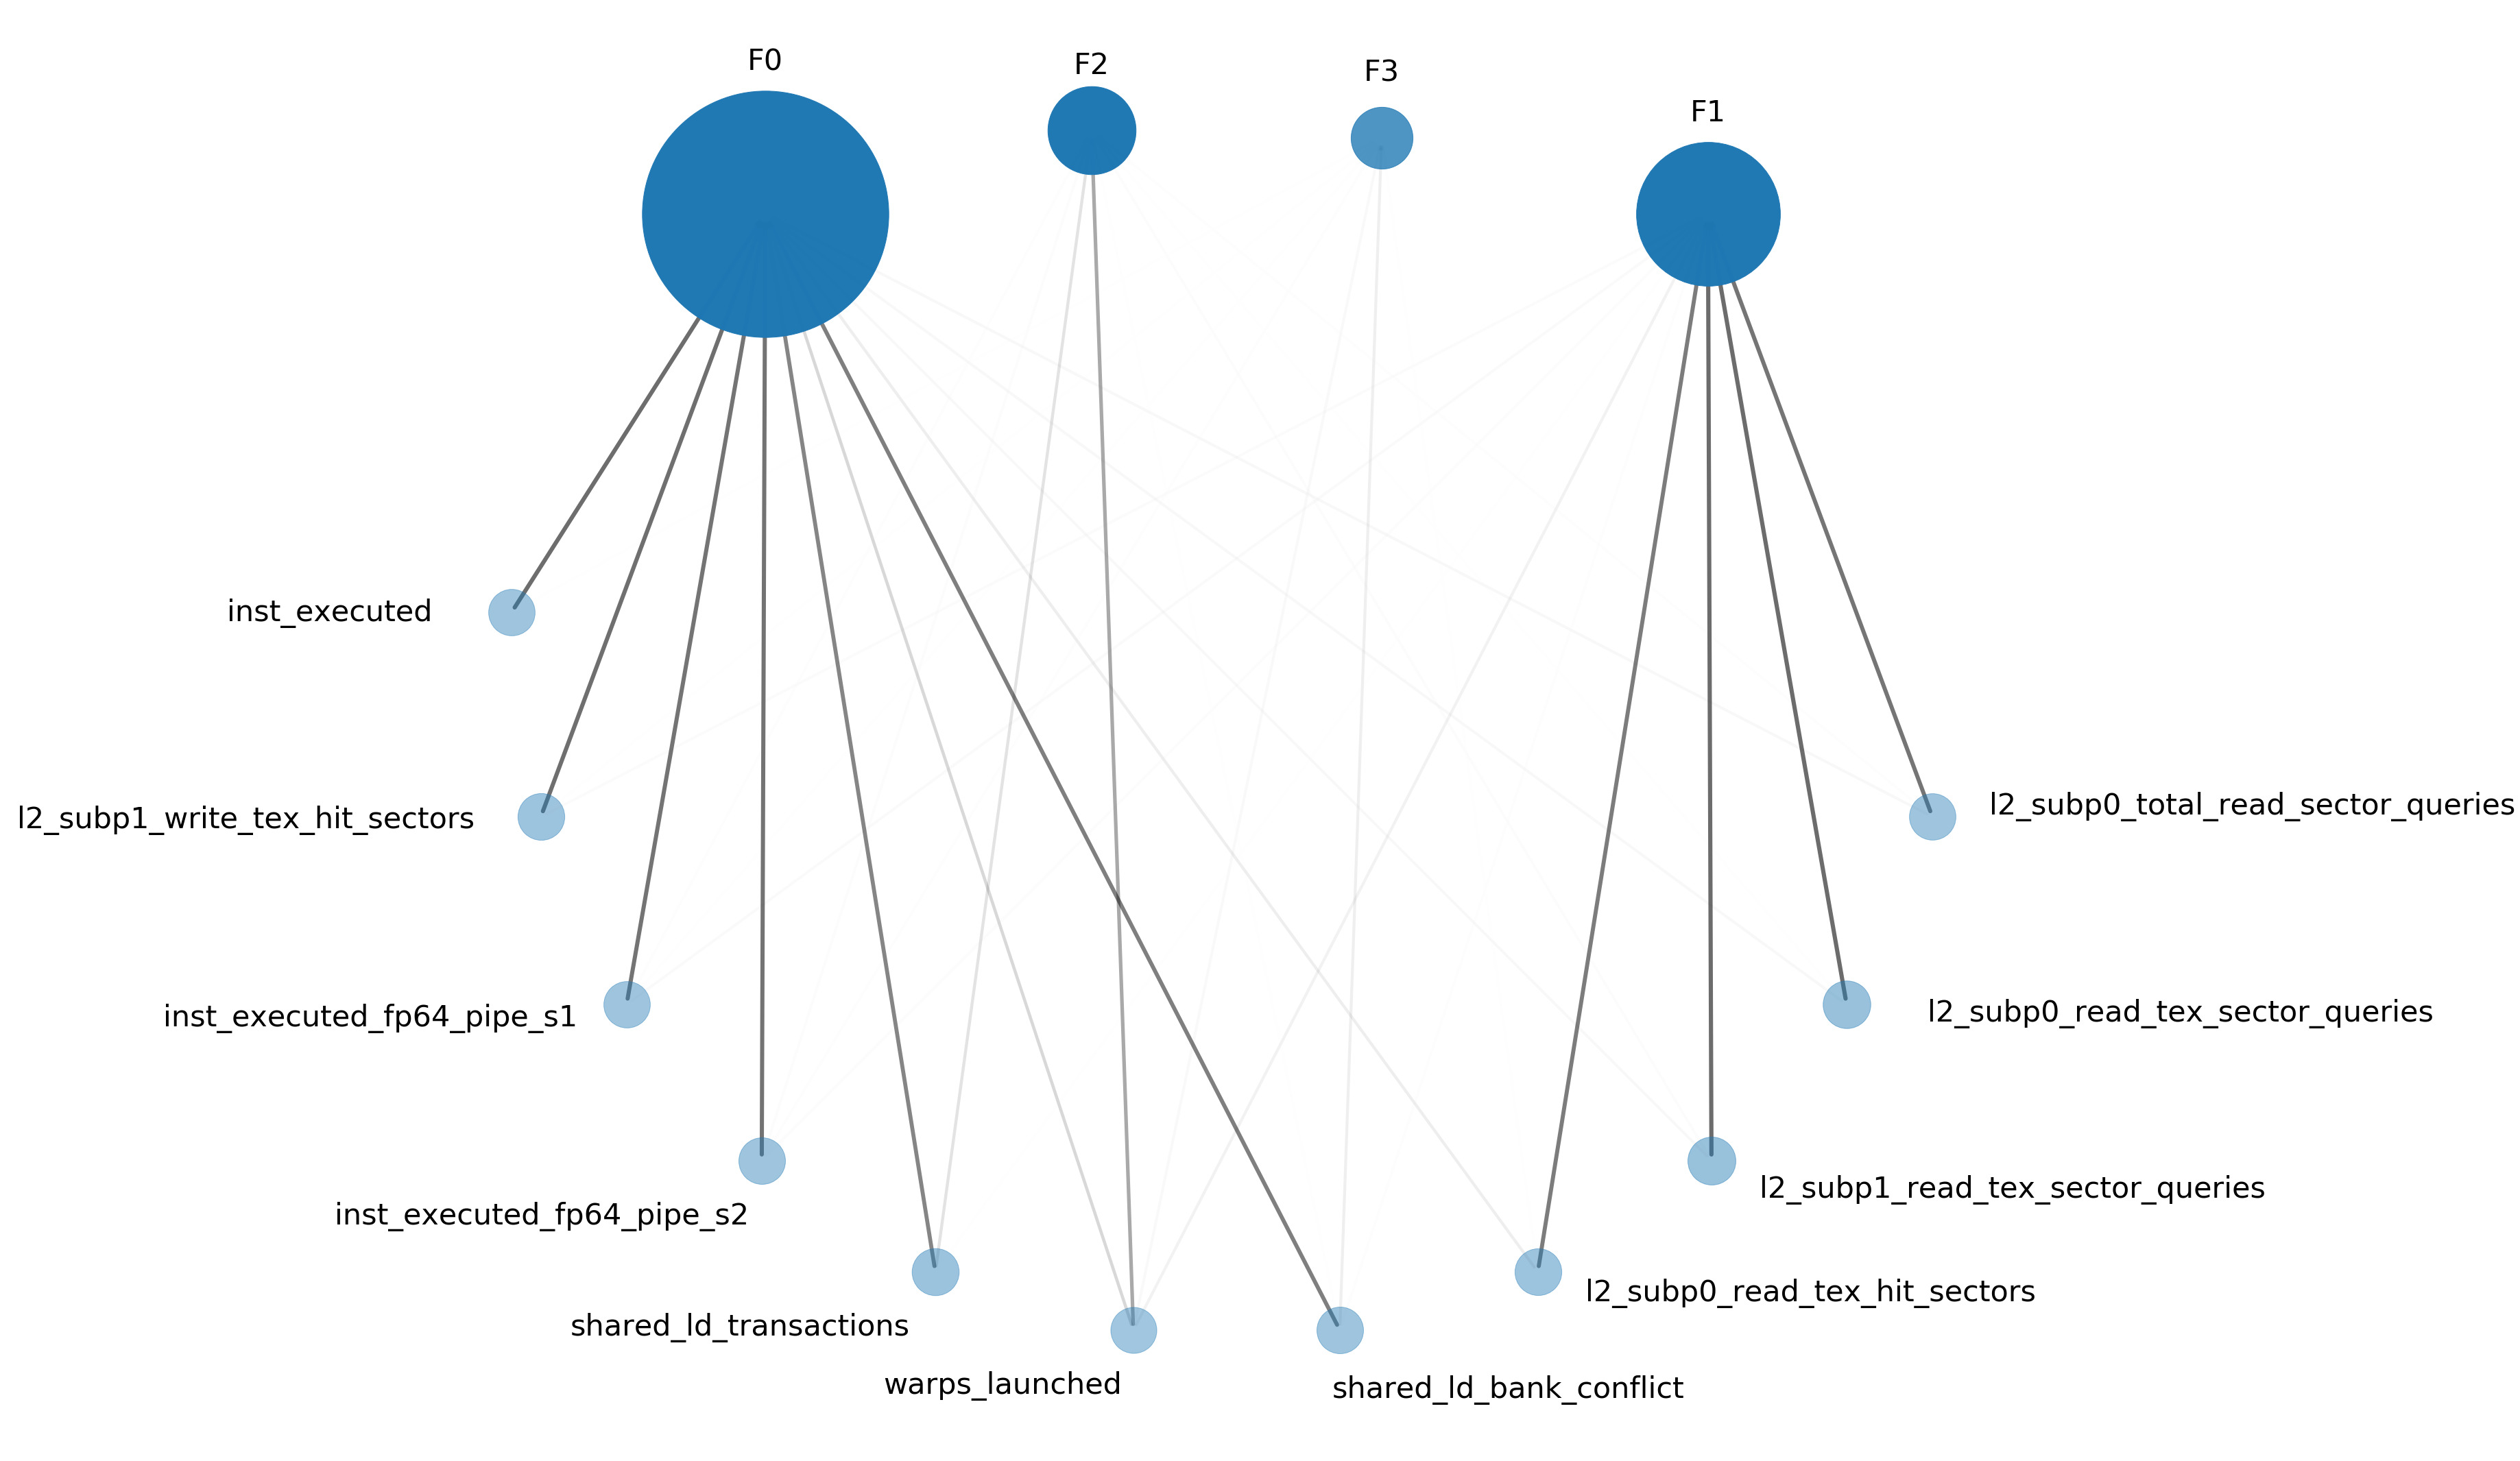

In [62]:
dotfile = subsetlist[0]
dotg, fixed_positions, labels, labelpos, edgeweights, nodeweights = preparedotgraph(dotfile,dopos=None,minweight=1.4,midgap=0.142)#,radiusdivisor=1)
print("labels = " + str(labels))
fixed_positions, labelpos = swappositions('n1_3','n1_1',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('n1_2','n1_3',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('18','43',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('23','40',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('34','39',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('9','39',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('34','23',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('9','23',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('33','9',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('52','34',fixed_positions,labelpos)

fixed_positions['n1_2'] = (fixed_positions['n1_2'][0]+0.1,fixed_positions['n1_2'][1]-0.135)
labelpos['n1_2'] = (fixed_positions['n1_2'][0],fixed_positions['n1_2'][1])
fixed_positions['n1_3'] = (fixed_positions['n1_3'][0]-0.1,fixed_positions['n1_3'][1]-0.145)
labelpos['n1_3'] = (fixed_positions['n1_3'][0],fixed_positions['n1_3'][1])

labelpos['n1_0'] = (labelpos['n1_0'][0],labelpos['n1_0'][1]+0.07)
labelpos['39'] = (labelpos['39'][0]-0.07,labelpos['39'][1])
labelpos['11'] = (labelpos['11'][0]-0.1,labelpos['11'][1]+0.06)
labelpos['43'] = (labelpos['43'][0]-0.1,labelpos['43'][1]+0.1)
labelpos['40'] = (labelpos['40'][0]-0.1,labelpos['40'][1]+0.1)
labelpos['9'] = (labelpos['9'][0]-0.14,labelpos['9'][1]+0.11)
labelpos['23'] = (labelpos['23'][0]-0.13,labelpos['23'][1]+0.09)
labelpos['34'] = (labelpos['34'][0]+0.1,labelpos['34'][1]+0.08)
labelpos['49'] = (labelpos['49'][0]+0.15,labelpos['49'][1]+0.12)
labelpos['18'] = (labelpos['18'][0]+0.16,labelpos['18'][1]+0.15)
labelpos['52'] = (labelpos['52'][0]+0.2,labelpos['52'][1]+0.18)
labelpos['33'] = (labelpos['33'][0]+0.16,labelpos['33'][1]+0.125)
labelpos['n1_2'] = (labelpos['n1_2'][0],labelpos['n1_2'][1]-0.05)
labelpos['n1_3'] = (labelpos['n1_3'][0],labelpos['n1_3'][1]-0.05)
printnetworkx(g=dotg,pos=fixed_positions,edgeweights=edgeweights,
              figuresize=(50,30),fontsize=43,legend=labels,labelpos=labelpos,
              nodeweights=nodeweights,nodesizemult=3000,
              nodealpha=0,nodealphamult=.3,nodecmap='jet',#plt.get_cmap('jet'),
              edgealpha=0,edgemultalpha=0.4,
              basewidth=4,multwidth=1.5,pdfname="/home/chaseleif/Desktop/graphs/pennant_0_142")

full nodelist: 53: 0, n1_2, n1_0, n1_3, n1_1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 
deleting fixed n1_2
drop nodes = 32: ['0', 'n1_2', '1', '2', '3', '5', '6', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '24', '26', '28', '29', '31', '32', '34', '38', '40', '41', '43', '45', '46', '47']
read corex_output/Tree_dot_files/kripke_all_freq/tree.dot and ready to graph
labels = {'n1_0': 'F0', 'n1_3': 'F3', 'n1_1': 'F1', '4': 'l2_subp1_total_write_sector_queries', '7': 'inst_executed_fma_pipe_s2', '8': 'inst_executed_fma_pipe_s0', '9': 'l2_subp1_write_tex_hit_sectors', '21': 'warps_launched', '22': 'inst_executed_fp64_pipe_s0', '23': 'global_load', '25': 'inst_issued1', '27': 'inst_executed_fma_pipe_s1', '30': 'l2_subp0_total_read_sector_queries', '33': 'l2_subp0_write_tex_sector_queries', '35': 'inst_executed', '36': 'inst_exec

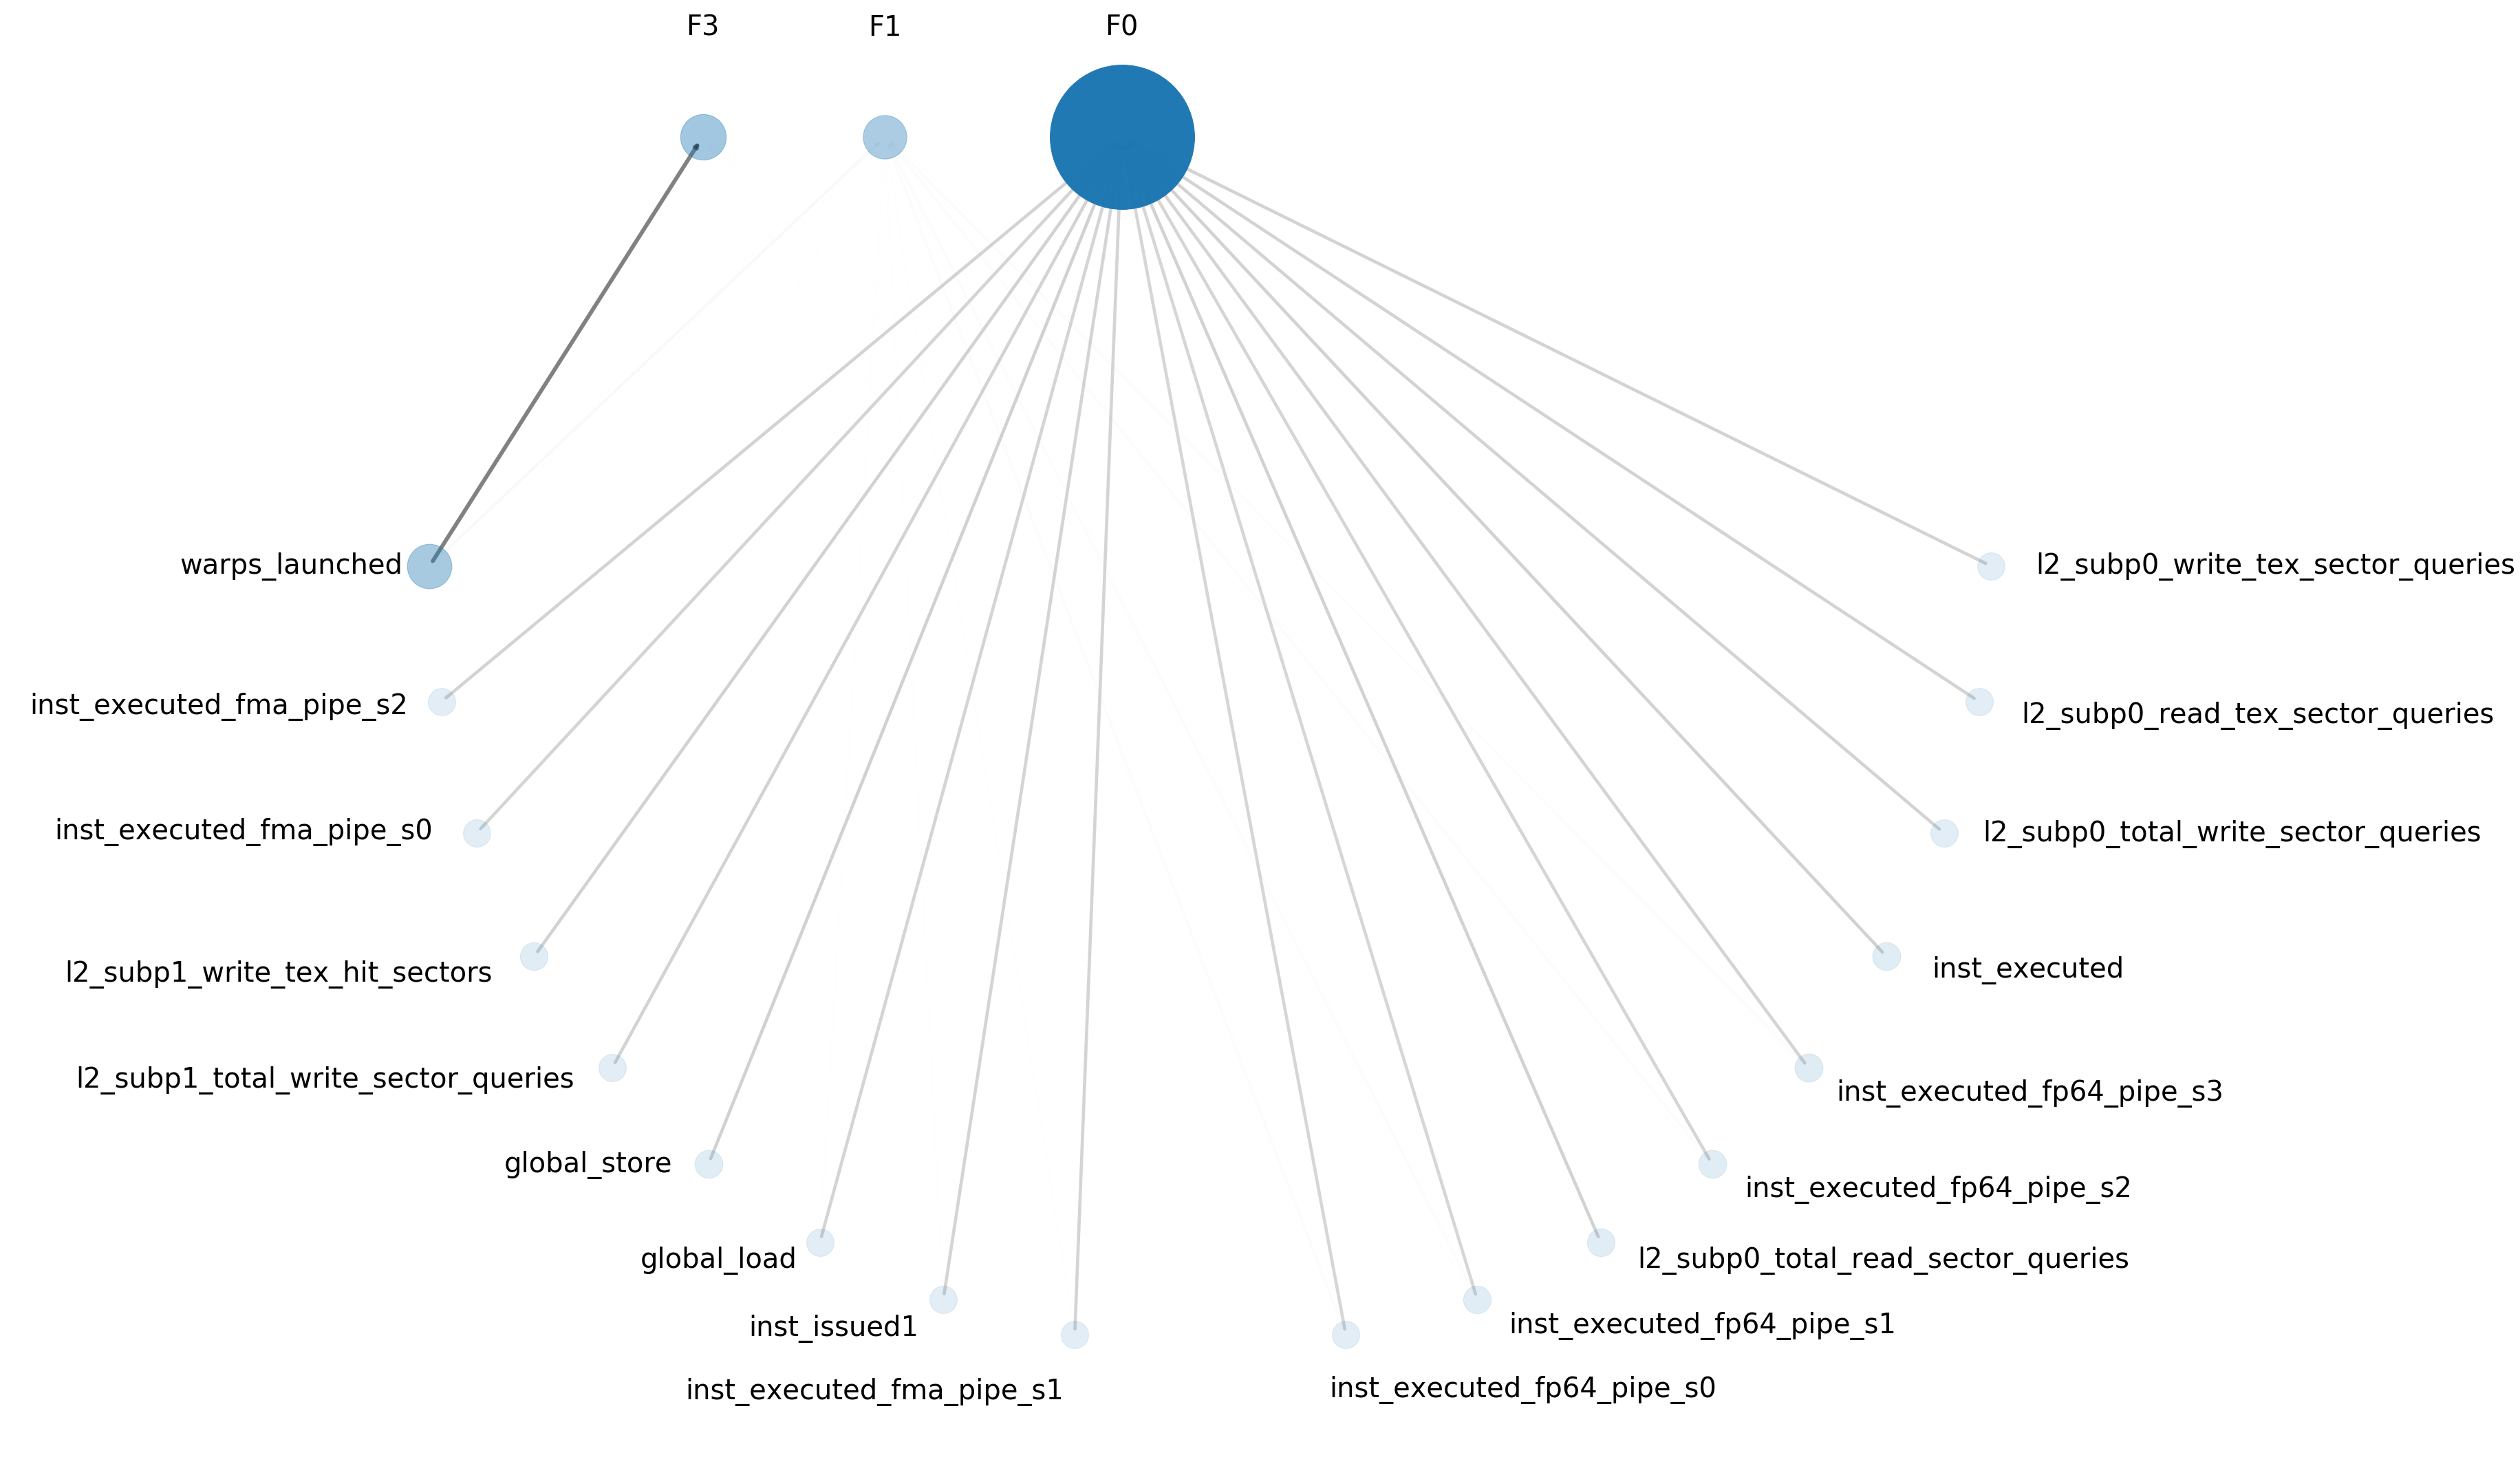

In [53]:
dotfile = subsetlist[1]
dotg, fixed_positions, labels, labelpos, edgeweights, nodeweights = preparedotgraph(dotfile,dopos=None,minweight=0.43)
print("labels = " + str(labels))
fixed_positions, labelpos = swappositions('n1_0','n1_3',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('4','21',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('48','33',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('48','30',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('39','30',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('48','22',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('35','30',fixed_positions,labelpos)

fixed_positions['n1_0'] = (fixed_positions['n1_0'][0]-0.33,fixed_positions['n1_0'][1])
labelpos['n1_0'] = (fixed_positions['n1_0'][0],fixed_positions['n1_0'][1])
fixed_positions['n1_1'] = (fixed_positions['n1_1'][0]-0.2,fixed_positions['n1_1'][1])
labelpos['n1_1'] = (fixed_positions['n1_1'][0],fixed_positions['n1_1'][1])


labelpos['33'] = (labelpos['33'][0]+0.05,labelpos['33'][1])
labelpos['44'] = (labelpos['44'][0]+0.05,labelpos['44'][1]+0.026)
labelpos['42'] = (labelpos['42'][0]+0.06,labelpos['42'][1]+0.08)
labelpos['35'] = (labelpos['35'][0]+0.035,labelpos['35'][1]+0.055)
labelpos['37'] = (labelpos['37'][0]+0.07,labelpos['37'][1]+0.105)
labelpos['36'] = (labelpos['36'][0]+0.1,labelpos['36'][1]+0.13)
labelpos['30'] = (labelpos['30'][0]+0.16,labelpos['30'][1]+0.185)
labelpos['39'] = (labelpos['39'][0]+0.16,labelpos['39'][1]+0.165)
labelpos['22'] = (labelpos['22'][0]+0.145,labelpos['22'][1]+0.145)

labelpos['7'] = (labelpos['7'][0]-0.03,labelpos['7'][1]+0.03)
labelpos['8'] = (labelpos['8'][0]-0.05,labelpos['8'][1]+0.07)
labelpos['9'] = (labelpos['9'][0]-0.07,labelpos['9'][1]+0.09)
labelpos['4'] = (labelpos['4'][0]-0.1,labelpos['4'][1]+0.14)
labelpos['48'] = (labelpos['48'][0]-0.05,labelpos['48'][1]+0.1)
labelpos['23'] = (labelpos['23'][0]-0.05,labelpos['23'][1]+0.09)
labelpos['25'] = (labelpos['25'][0]-0.077,labelpos['25'][1]+0.092)
labelpos['27'] = (labelpos['27'][0]-0.17,labelpos['27'][1]+0.14)

printnetworkx(g=dotg,pos=fixed_positions,edgeweights=edgeweights,
              figuresize=(50,30),fontsize=40,legend=labels,labelpos=labelpos,
              nodeweights=nodeweights,nodesizemult=3000,
              nodealpha=0,nodealphamult=.3,nodecmap='jet',#plt.get_cmap('jet'),
              edgealpha=0,edgemultalpha=0.4,
              basewidth=4,multwidth=1.5)#,pdfname="/home/chaseleif/Desktop/graphs/kripke_0_43")


In [12]:
print(fixed_positions)
print(labels)

{'n1_0': (-0.65, 0.55), 'n1_1': (-0.21666666666666667, 0.55), 'n1_3': (0.21666666666666667, 0.55), '4': (-1.0, 0.0), '7': (-0.984807753012208, -0.17364817766693033), '8': (-0.9396926207859084, -0.3420201433256687), '9': (-0.8660254037844387, -0.49999999999999994), '21': (-0.766044443118978, -0.6427876096865393), '22': (-0.6427876096865394, -0.766044443118978), '23': (-0.5000000000000001, -0.8660254037844386), '25': (-0.3420201433256688, -0.9396926207859083), '27': (-0.17364817766693041, -0.984807753012208), '30': (0.1736481776669303, -0.984807753012208), '33': (0.3420201433256685, -0.9396926207859084), '35': (0.4999999999999998, -0.8660254037844387), '36': (0.6427876096865394, -0.766044443118978), '37': (0.7660444431189779, -0.6427876096865395), '39': (0.8660254037844385, -0.5000000000000003), '42': (0.9396926207859083, -0.3420201433256689), '44': (0.984807753012208, -0.17364817766693028), '48': (1.0, -1.2246467991473532e-16)}
{'n1_0': 'F0', 'n1_3': 'F3', 'n1_1': 'F1', '4': 'l2_subp1_t

full nodelist: 51: 0, n1_2, n1_0, n1_3, n1_1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 
drop nodes = 36: ['0', '1', '2', '3', '4', '5', '9', '10', '11', '12', '14', '15', '16', '17', '20', '22', '23', '24', '25', '26', '28', '29', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '45']
read corex_output/Tree_dot_files/all_apps_all_freq/tree.dot and ready to graph
labels = {'n1_2': 'F2', 'n1_0': 'F0', 'n1_3': 'F3', 'n1_1': 'F1', '6': 'inst_executed_fma_pipe_s3', '7': 'inst_executed_fma_pipe_s2', '8': 'inst_executed_fma_pipe_s0', '13': 'thread_inst_executed', '18': 'not_predicated_off_thread_inst_executed', '19': 'sm_cta_launched', '21': 'warps_launched', '27': 'inst_executed_fma_pipe_s1', '30': 'l2_subp1_read_tex_hit_sectors', '44': 'l2_subp0_read_tex_hit_sectors', '46': 'global_store'}


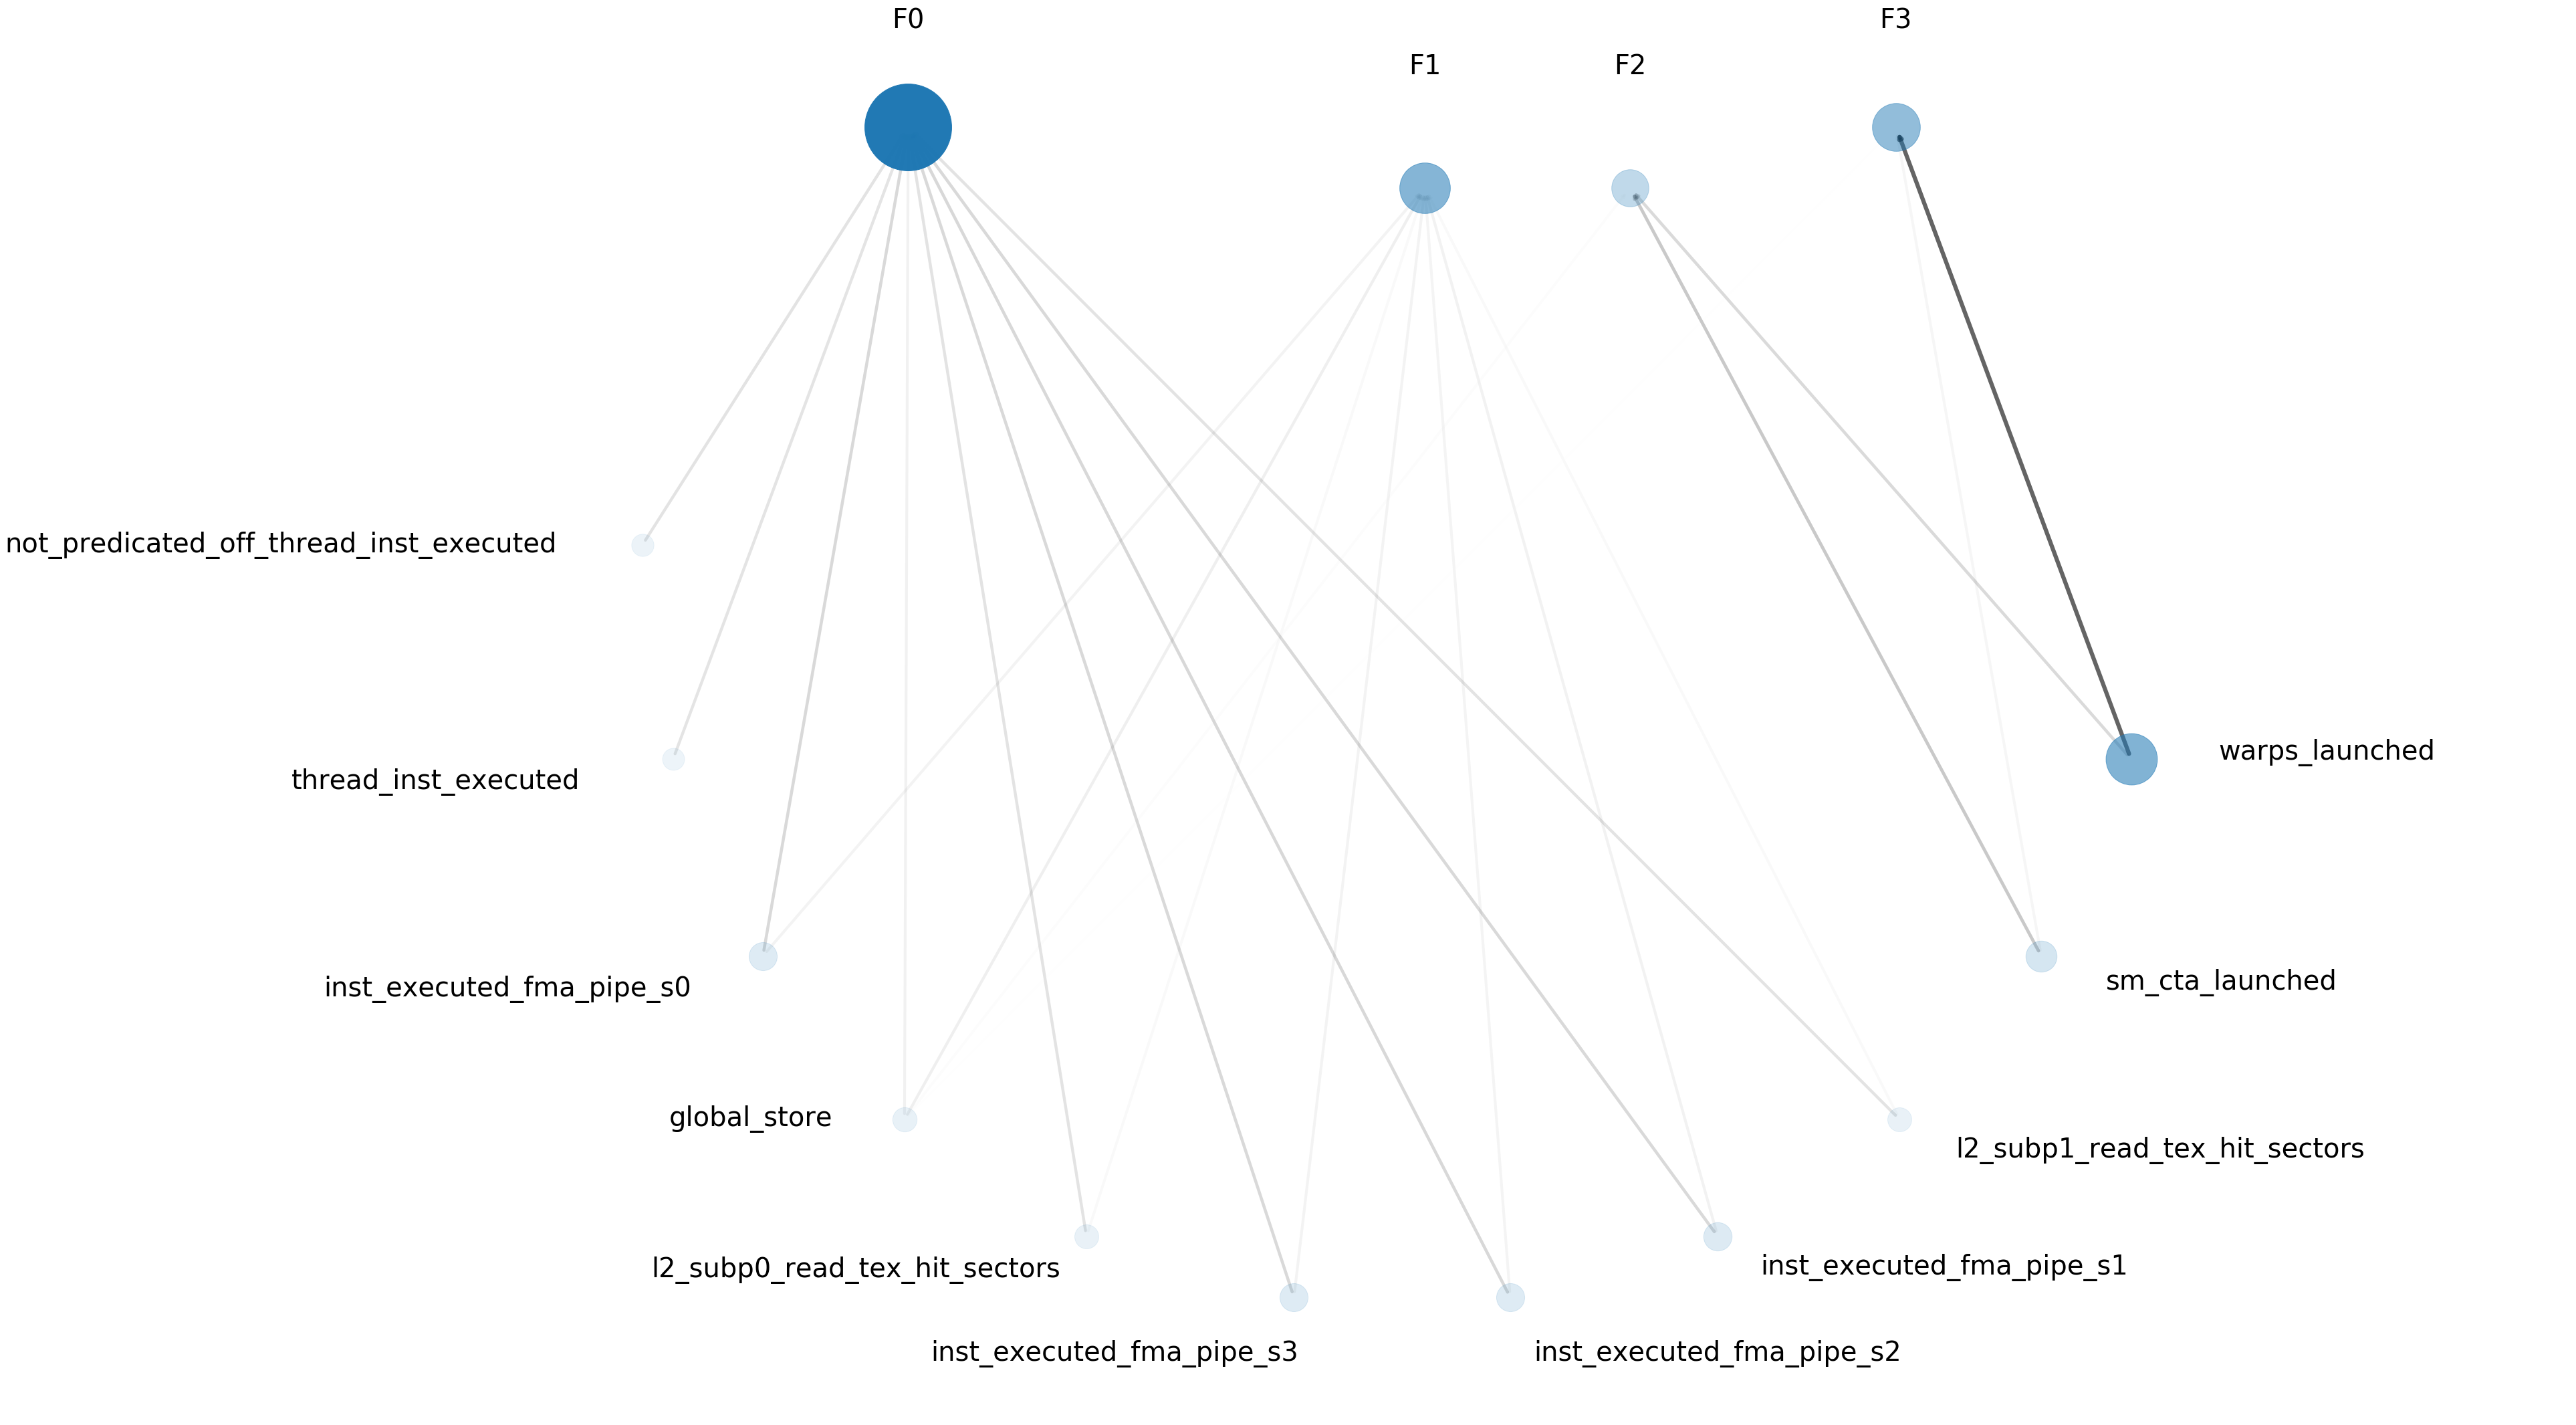

In [31]:
dotfile = subsetlist[2]
dotg, fixed_positions, labels, labelpos, edgeweights, nodeweights = preparedotgraph(dotfile,dopos=None,minweight=0.25)
print("labels = " + str(labels))
fixed_positions, labelpos = swappositions('13','46',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('18','44',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('18','19',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('21','13',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('18','6',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('13','7',fixed_positions,labelpos)

fixed_positions['n1_1'] = (fixed_positions['n1_1'][0]+0.33,fixed_positions['n1_1'][1]-0.33)
labelpos['n1_1'] = (fixed_positions['n1_1'][0],fixed_positions['n1_1'][1]+0.02)
fixed_positions['n1_2'] = (fixed_positions['n1_2'][0],fixed_positions['n1_2'][1]-0.33)
labelpos['n1_2'] = (fixed_positions['n1_2'][0],fixed_positions['n1_2'][1]+0.02)
labelpos['n1_0'] = (fixed_positions['n1_0'][0],fixed_positions['n1_0'][1])
labelpos['n1_3'] = (fixed_positions['n1_3'][0],fixed_positions['n1_3'][1])

labelpos['18'] = (labelpos['18'][0]-0.1,labelpos['18'][1])
labelpos['13'] = (labelpos['13'][0]-0.09,labelpos['13'][1]+0.025)
labelpos['8'] = (labelpos['8'][0]-0.1,labelpos['8'][1]+0.074)
labelpos['46'] = (labelpos['46'][0]-0.09,labelpos['46'][1]+0.1)
labelpos['44'] = (labelpos['44'][0]-0.15,labelpos['44'][1]+0.16)
labelpos['6'] = (labelpos['6'][0]-0.16,labelpos['6'][1]+0.14)

labelpos['21'] = (labelpos['21'][0]+0.075,labelpos['21'][1]+0.05)
labelpos['19'] = (labelpos['19'][0]+0.07,labelpos['19'][1]+0.055)
labelpos['30'] = (labelpos['30'][0]+0.13,labelpos['30'][1]+0.13)
labelpos['27'] = (labelpos['27'][0]+0.155,labelpos['27'][1]+0.15)
labelpos['7'] = (labelpos['7'][0]+0.19,labelpos['7'][1]+0.14)

printnetworkx(g=dotg,pos=fixed_positions,edgeweights=edgeweights,
              figuresize=(50,30),fontsize=40,legend=labels,labelpos=labelpos,
              nodeweights=nodeweights,nodesizemult=3000,
              nodealpha=0,nodealphamult=.3,nodecmap='jet',#plt.get_cmap('jet'),
              edgealpha=0,edgemultalpha=0.4,
              basewidth=4,multwidth=1.5)#,pdfname="/home/chaseleif/Desktop/graphs/all_apps_all_freq_0_25")


In [14]:
print(fixed_positions)
print(labels)

{'n1_0': (-0.65, 0.55), 'n1_1': (-0.3, 0.8), 'n1_2': (0.3, 0.8), 'n1_3': (0.65, 0.55), '6': (-1.0, 0.0), '7': (-0.9749279121818236, -0.2225209339563144), '8': (-0.9009688679024191, -0.4338837391175581), '13': (-0.7818314824680298, -0.6234898018587335), '18': (-0.6234898018587336, -0.7818314824680298), '19': (-0.4338837391175582, -0.9009688679024191), '21': (-0.22252093395631445, -0.9749279121818236), '23': (0.22252093395631434, -0.9749279121818236), '25': (0.43388373911755806, -0.9009688679024191), '27': (0.6234898018587335, -0.7818314824680299), '30': (0.7818314824680295, -0.6234898018587339), '34': (0.900968867902419, -0.43388373911755823), '44': (0.9749279121818237, -0.2225209339563141), '46': (1.0, -1.2246467991473532e-16)}
{'n1_2': 'F2', 'n1_0': 'F0', 'n1_3': 'F3', 'n1_1': 'F1', '6': 'inst_executed_fma_pi', '7': 'inst_executed_fma_pi', '8': 'inst_executed_fma_pi', '13': 'thread_inst_executed', '18': 'not_predicated_off_t', '19': 'sm_cta_launched', '21': 'warps_launched', '23': 'gl

In [16]:
print(fixed_positions)
print(labels)

{'n1_0': (-0.65, 0.55), 'n1_1': (-0.3, 0.8), 'n1_2': (0.3, 0.8), 'n1_3': (0.65, 0.55), '4': (-1.0, 0.0), '6': (-0.9781476007338057, -0.20791169081775931), '7': (-0.9135454576426009, -0.40673664307580015), '8': (-0.8090169943749475, -0.5877852522924731), '9': (-0.6691306063588582, -0.7431448254773942), '10': (-0.5000000000000001, -0.8660254037844386), '12': (-0.30901699437494745, -0.9510565162951535), '13': (-0.10452846326765346, -0.9945218953682733), '15': (0.10452846326765333, -0.9945218953682734), '25': (0.30901699437494734, -0.9510565162951536), '31': (0.4999999999999998, -0.8660254037844387), '35': (0.6691306063588579, -0.7431448254773945), '46': (0.8090169943749473, -0.5877852522924732), '50': (0.913545457642601, -0.40673664307580004), '53': (0.9781476007338057, -0.20791169081775931)}
{'n1_2': 'F2', 'n1_0': 'F0', 'n1_3': 'F3', 'n1_1': 'F1', '4': 'l2_subp1_total_write', '6': 'inst_executed_fma_pi', '7': 'inst_executed_fma_pi', '8': 'inst_executed_fma_pi', '9': 'shared_ld_transactio

full nodelist: 60: 0, n1_2, n1_0, n1_3, n1_1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 
drop nodes = 41: ['0', '1', '2', '3', '5', '11', '14', '16', '17', '18', '19', '20', '21', '22', '23', '24', '26', '27', '28', '29', '30', '32', '33', '34', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '47', '48', '49', '51', '52', '54', '55']
read corex_output/Tree_dot_files/minife_all_freq/tree.dot and ready to graph
labels = {'n1_2': 'F2', 'n1_0': 'F0', 'n1_3': 'F3', 'n1_1': 'F1', '4': 'l2_subp1_total_write_sector_queries', '6': 'inst_executed_fma_pipe_s3', '7': 'inst_executed_fma_pipe_s2', '8': 'inst_executed_fma_pipe_s0', '9': 'shared_ld_transactions', '10': 'shared_load', '12': 'shared_st_transactions', '13': 'l2_subp1_total_read_sector_queries', '15': 'thread_inst_executed', '25': 'global_load', '31': 'inst_exe

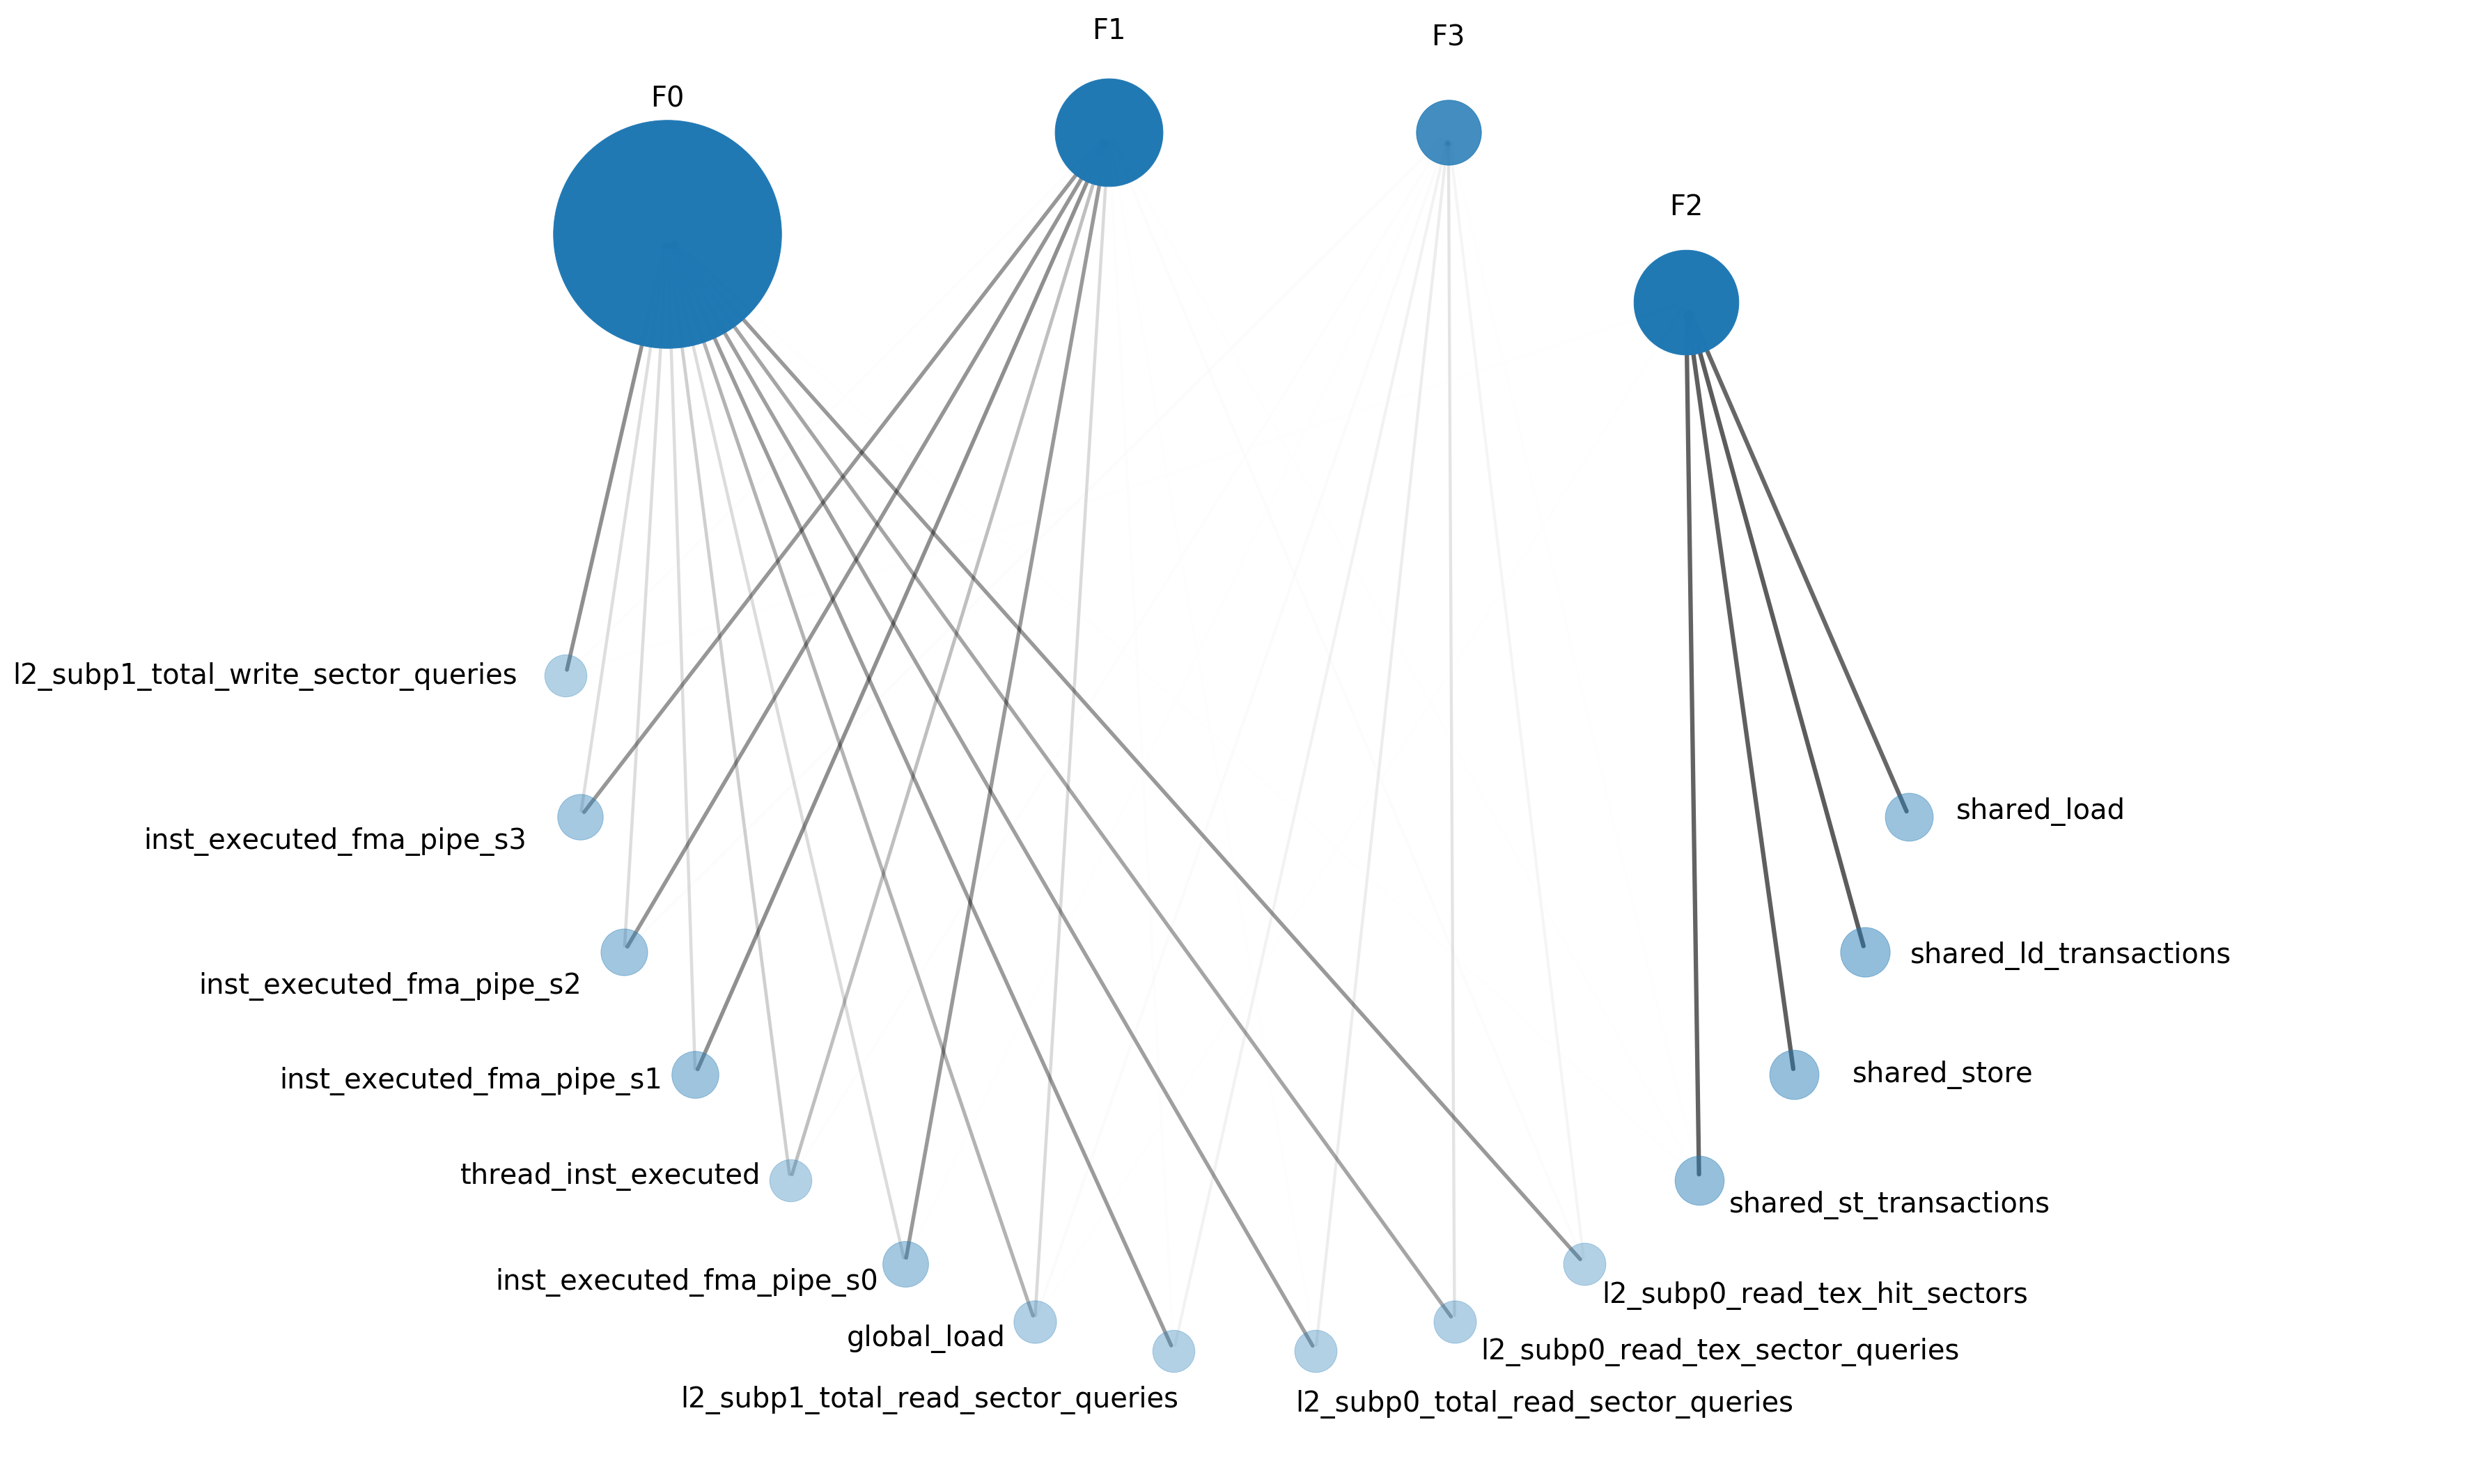

In [12]:
dotfile = subsetlist[3]
dotg, fixed_positions, labels, labelpos, edgeweights, nodeweights = preparedotgraph(dotfile,dopos=None,minweight=1.119)
print("labels = " + str(labels))
#labelpos['n1_0'] = (labelpos['n1_0'][0],labelpos['n1_0'][1]+0.07)
fixed_positions, labelpos = swappositions('8','53',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('9','50',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('8','10',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('12','35',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('n1_2','n1_3',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('31','53',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('25','50',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('15','35',fixed_positions,labelpos)
fixed_positions, labelpos = swappositions('15','25',fixed_positions,labelpos)

fixed_positions['n1_0'] = (fixed_positions['n1_0'][0]-0.2,fixed_positions['n1_0'][1]+0.1)
labelpos['n1_0'] = (fixed_positions['n1_0'][0],fixed_positions['n1_0'][1]+0.06)
fixed_positions['n1_1'] = (fixed_positions['n1_1'][0]+0.1,fixed_positions['n1_1'][1])
labelpos['n1_1'] = (fixed_positions['n1_1'][0],fixed_positions['n1_1'][1]+0.01)


labelpos['4'] = (labelpos['4'][0]-0.1,labelpos['4'][1])
labelpos['6'] = (labelpos['6'][0]-0.09,labelpos['6'][1]+0.014)
labelpos['7'] = (labelpos['7'][0]-0.09,labelpos['7'][1]+0.042)
labelpos['31'] = (labelpos['31'][0]-0.1,labelpos['31'][1]+0.112)
labelpos['25'] = (labelpos['25'][0]-0.1,labelpos['25'][1]+0.1)
labelpos['8'] = (labelpos['8'][0]-0.155,labelpos['8'][1]+0.1536)
labelpos['35'] = (labelpos['35'][0]+0.233,labelpos['35'][1]+0.175)

labelpos['13'] = (labelpos['13'][0]-0.25,labelpos['13'][1]+0.18)


labelpos['10'] = (labelpos['10'][0]+0.04,labelpos['10'][1]+0.035)
labelpos['9'] = (labelpos['9'][0]+0.08,labelpos['9'][1]+0.07)
labelpos['46'] = (labelpos['46'][0]+0.08,labelpos['46'][1]+0.08)
labelpos['12'] = (labelpos['12'][0]+0.107,labelpos['12'][1]+0.107)
labelpos['53'] = (labelpos['53'][0]+0.159,labelpos['53'][1]+0.15)

labelpos['50'] = (labelpos['50'][0]+0.23,labelpos['50'][1]+0.185)
labelpos['15'] = (labelpos['15'][0]-0.1,labelpos['15'][1]+0.136)

printnetworkx(g=dotg,pos=fixed_positions,edgeweights=edgeweights,
              figuresize=(50,30),fontsize=40,legend=labels,labelpos=labelpos,
              nodeweights=nodeweights,nodesizemult=3000,
              nodealpha=0,nodealphamult=.3,nodecmap='jet',#plt.get_cmap('jet'),
              edgealpha=0,edgemultalpha=0.4,
              basewidth=4,multwidth=1.5,pdfname="/home/chaseleif/Desktop/graphs/minife_1_119")


In [344]:
fixed_positions

{'n1_0': (-0.65, 0.55),
 'n1_1': (-0.3, 0.8),
 '4': (-1.0, 0.0),
 '6': (-0.9781476007338057, -0.20791169081775931),
 '7': (-0.9135454576426009, -0.40673664307580015),
 '13': (-0.10452846326765346, -0.9945218953682733),
 '15': (0.10452846326765333, -0.9945218953682734),
 '46': (0.8090169943749473, -0.5877852522924732),
 '9': (0.913545457642601, -0.40673664307580004),
 '8': (-0.5000000000000001, -0.8660254037844386),
 '10': (0.9781476007338057, -0.20791169081775931),
 '12': (0.6691306063588579, -0.7431448254773945),
 '35': (-0.30901699437494745, -0.9510565162951535),
 'n1_2': (0.65, 0.55),
 'n1_3': (0.3, 0.8),
 '31': (-0.8090169943749475, -0.5877852522924731),
 '53': (0.4999999999999998, -0.8660254037844387),
 '25': (-0.6691306063588582, -0.7431448254773942),
 '50': (0.30901699437494734, -0.9510565162951536)}